### Show of drawback of not automating this process

In [9]:
import uproot
import awkward as ak
import numpy as np
import vector  # optional, for physics behaviors

In [10]:
file = uproot.open("../pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_5.2623.eicrecon.edm4eic.root")
tree = file["events"]

# Choose the branches we want (you can inspect tree.keys())
branches = [
    "B0ECalClusters/B0ECalClusters.type",
    "B0ECalClusters/B0ECalClusters.energy",
    "B0ECalClusters/B0ECalClusters.time",
    "B0ECalClusters/B0ECalClusters.nhits",
    "B0ECalClusters/B0ECalClusters.position.x",
    "B0ECalClusters/B0ECalClusters.position.y",
    "B0ECalClusters/B0ECalClusters.position.z",
    # ... add more fields as needed ...
    "B0ECalRecHits/B0ECalRecHits.cellID",
    "B0ECalRecHits/B0ECalRecHits.energy",
    "B0ECalRecHits/B0ECalRecHits.time",
    "B0ECalRecHits/B0ECalRecHits.position.x",
    "B0ECalRecHits/B0ECalRecHits.position.y",
    "B0ECalRecHits/B0ECalRecHits.position.z",
]

# Read the branches into an awkward "dict of arrays"
arrays = tree.arrays(branches, library="ak")

# Short names for convenience
cl_type = arrays["B0ECalClusters/B0ECalClusters.type"]
cl_energy = arrays["B0ECalClusters/B0ECalClusters.energy"]
cl_time = arrays["B0ECalClusters/B0ECalClusters.time"]
cl_nhits = arrays["B0ECalClusters/B0ECalClusters.nhits"]
cl_x = arrays["B0ECalClusters/B0ECalClusters.position.x"]
cl_y = arrays["B0ECalClusters/B0ECalClusters.position.y"]
cl_z = arrays["B0ECalClusters/B0ECalClusters.position.z"]

rh_cell = arrays["B0ECalRecHits/B0ECalRecHits.cellID"]
rh_energy = arrays["B0ECalRecHits/B0ECalRecHits.energy"]
rh_time = arrays["B0ECalRecHits/B0ECalRecHits.time"]
rh_x = arrays["B0ECalRecHits/B0ECalRecHits.position.x"]
rh_y = arrays["B0ECalRecHits/B0ECalRecHits.position.y"]
rh_z = arrays["B0ECalRecHits/B0ECalRecHits.position.z"]

In [11]:
# A lot of manual work
# Cluster record
b0_ecal_clusters = ak.zip(
    {
        "type": cl_type,
        "energy": cl_energy,
        "time": cl_time,
        "nhits": cl_nhits,
        "position": ak.zip({"x": cl_x, "y": cl_y, "z": cl_z}),
    },
    with_name="B0ECalCluster",
)

# RecHit record
b0_ecal_rechits = ak.zip(
    {
        "cellID": rh_cell,
        "energy": rh_energy,
        "time": rh_time,
        "position": ak.zip({"x": rh_x, "y": rh_y, "z": rh_z}),
    },
    with_name="B0ECalRecHit",
)


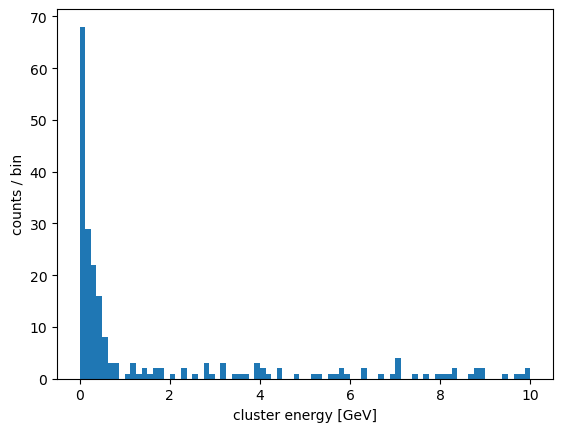

In [12]:
# Now `b0_ecal_clusters` is an array-of-arrays (events → clusters → fields)
# and `b0_ecal_rechits` is events → rechits → fields.

# Example use: flattened distributions
import matplotlib.pyplot as plt
plt.hist(ak.flatten(b0_ecal_clusters.energy), bins=80, range=(0, 10))
plt.xlabel("cluster energy [GeV]")
plt.ylabel("counts / bin")
plt.show()


## Here is another example of a custom way to do it

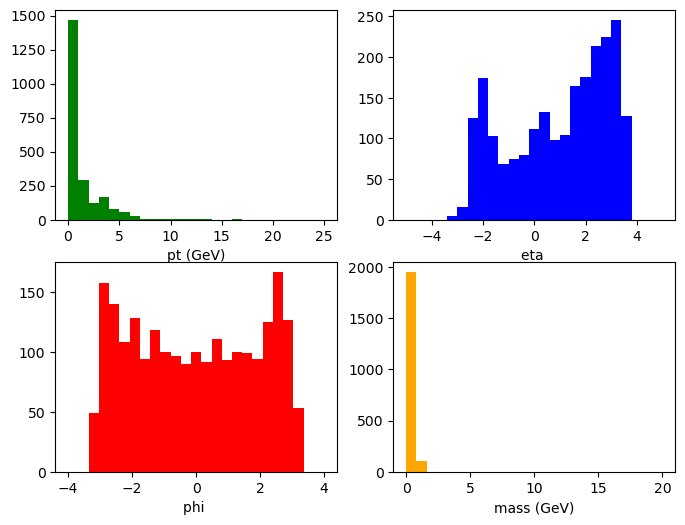

In [13]:
import awkward as ak
import vector
import uproot

class EIC_NTuples:
    def __init__(self):
        self.bs = vector.backends.awkward.behavior

    def __call__(self, data_tree):
        final_data = {}
        keys = data_tree.keys()
        collections = [item for item in keys if "/" not in item]

        for collection_name in collections:
            data = {}
            for item in keys:
                if collection_name == item.split("/")[0] and len(item.split("/")) >= 2:
                    field = item.split("/")[-1]
                    arr = data_tree.arrays([item], library="ak")[item]

                    if "momentum.x" in field:
                        data["px"] = arr
                    elif "momentum.y" in field:
                        data["py"] = arr
                    elif "momentum.z" in field:
                        data["pz"] = arr
                    elif "energy" in field:
                        data["E"] = arr
                    elif "mass" in field:
                        data["mass"] = arr
                    elif "position.x" in field:
                        data["x"] = arr
                    elif "position.y" in field:
                        data["y"] = arr
                    elif "position.z" in field:
                        data["z"] = arr
                    else:
                        clean_name = field.replace(".", "_")
                        data[clean_name] = arr

            try:
                if all(k in data for k in ("px", "py", "pz", "E")):
                    final_data[collection_name] = ak.zip(
                        data, with_name="Momentum4D", behavior=self.bs
                    )
                elif all(k in data for k in ("px", "py", "pz", "mass")):
                    final_data[collection_name] = ak.zip(
                        data, with_name="Momentum4D", behavior=self.bs
                    )
                elif all(k in data for k in ("px", "py", "pz")):
                    final_data[collection_name] = ak.zip(
                        data, with_name="Momentum3D", behavior=self.bs
                    )
                else:
                    final_data[collection_name] = ak.zip(data)
            except Exception as e:
                continue

        event_data = ak.Array(final_data, behavior=self.bs)
        return event_data
data = uproot.open("../pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_5.2623.eicrecon.edm4eic.root")
data_tree = data["events;5"]

event = EIC_NTuples()
events = event(data_tree)
fig , ax = plt.subplots(2,2,figsize = (8,6))
ax[0,0].hist(ak.flatten(events.ReconstructedChargedParticles.pt) , bins = 25 ,range = (0,25),color = "green")
ax[0,0].set_xlabel("pt (GeV)")
ax[0,1].hist(ak.flatten(events.ReconstructedChargedParticles.eta) , bins = 25 ,range = (-5,5) ,color = "blue")
ax[0,1].set_xlabel("eta ")
ax[1,0].hist(ak.flatten(events.ReconstructedChargedParticles.phi) , bins = 25 ,range = (-4,4) ,color = "red")
ax[1,0].set_xlabel("phi ")
ax[1,1].hist(ak.flatten(events.ReconstructedChargedParticles.mass) , bins = 25 ,range = (0,20) ,color = "orange")
ax[1,1].set_xlabel("mass (GeV)")
plt.savefig("charged_particle_track_momentum.png")
plt.show()

## Automatic grouping into Awkward record arrays with Awkward-zipper

In [14]:
# Build Awkward-zipper library from source
# !pip install git+https://github.com/maxymnaumchyk/awkward-zipper.git

In [15]:
import awkward_zipper as az
help(az)

Help on package awkward_zipper:

NAME
    awkward_zipper

PACKAGE CONTENTS
    awkward_util
    behaviors (package)
    kernels
    layouts (package)

CLASSES
    builtins.object
        awkward_zipper.layouts.base.BaseLayoutBuilder
            awkward_zipper.layouts.nanoaod.NanoAOD
                awkward_zipper.layouts.nanoaod.PFNanoAOD
                awkward_zipper.layouts.nanoaod.ScoutingNanoAOD

    class BaseLayoutBuilder(builtins.object)
     |  Base class for all layout builders
     |
     |  Class methods defined here:
     |
     |  behavior()
     |      Behaviors necessary to implement this schema (dict)
     |
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |
     |  __dict__
     |      dictionary for instance variables
     |
     |  __weakref__
     |      list of weak references to the object
     |
     |  ----------------------------------------------------------------------
     |  Data and